# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32

In [4]:
resources_folder = 'resources/classification'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

print(len(data))
print(data[0].shape)
print(data[0][0].shape)

loaded numpy bitmaps, 8 classes
8
(144722, 784)
(784,)


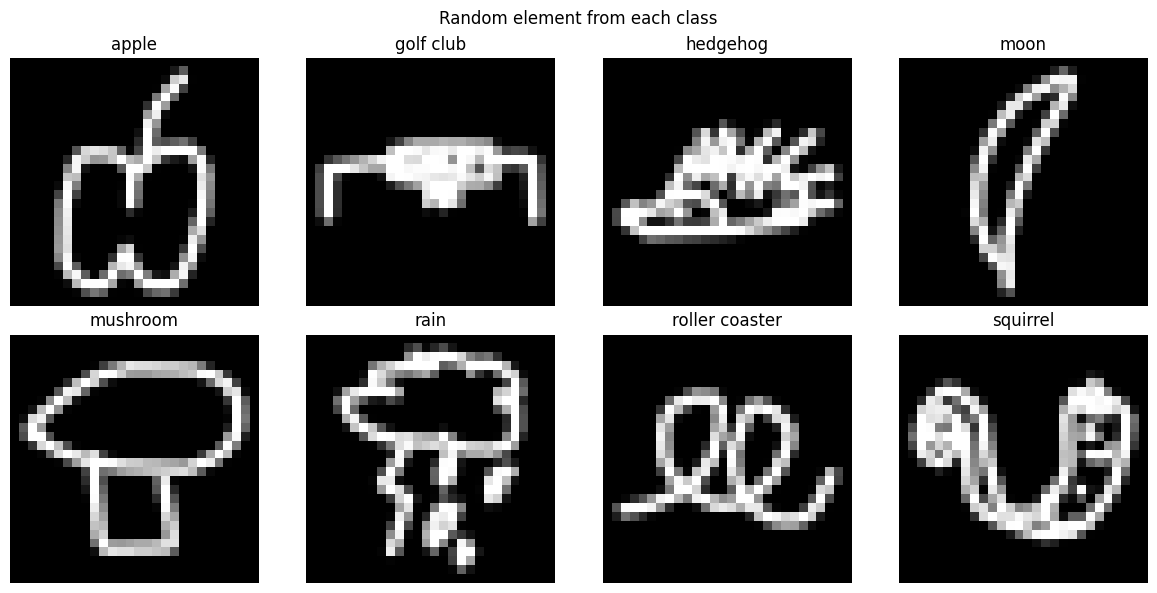

In [5]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManager import DataManager

data_manager = DataManager()

split = 0.8
training_data, training_labels, validation_data, validation_labels = data_manager.split_data(split, data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

In [8]:
from dataset_creation.GraysacleDataset import GrayscaleDataset

len_subset = 2000
valid_test_subset = 500

training_set = GrayscaleDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)
validation_set = GrayscaleDataset(data=shuffled_validation_data[:valid_test_subset], labels=shuffled_validation_labels[:valid_test_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

## Autoencoder class

In [9]:
from src.linear_autoencoder import LinearAutoencoder
from src.linear_autoencoder_embed import LinearAutoencoderEmbed

## Try with simple model

In [10]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 2]
#autoencoder_model = LinearAutoencoder(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True, encode_class=True)
autoencoder_model = LinearAutoencoderEmbed(architecture_1, device, WIDTH, HEIGHT, classes,
                                            dropout=0.3, batch_norm=True, class_number=len(classes))
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [11]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=392, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=392, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 2.0


In [12]:
num_epochs = 40
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.0664	Test Loss 0.0700	Train PSNR: 11.8732	Train SSIM: 0.1654	Validation PSNR: 11.6579	Validation SSIM: 0.1604
Epoch [2/40]	Loss: 0.0526	Test Loss 0.0523	Train PSNR: 13.1148	Train SSIM: 0.2077	Validation PSNR: 12.8009	Validation SSIM: 0.1957
Epoch [3/40]	Loss: 0.0398	Test Loss 0.0458	Train PSNR: 14.3311	Train SSIM: 0.2931	Validation PSNR: 13.8655	Validation SSIM: 0.2753
Epoch [4/40]	Loss: 0.0334	Test Loss 0.0371	Train PSNR: 15.3897	Train SSIM: 0.3550	Validation PSNR: 14.7786	Validation SSIM: 0.3348
Epoch [5/40]	Loss: 0.0230	Test Loss 0.0314	Train PSNR: 16.3159	Train SSIM: 0.4095	Validation PSNR: 15.5516	Validation SSIM: 0.3844
Epoch [6/40]	Loss: 0.0244	Test Loss 0.0283	Train PSNR: 17.1561	Train SSIM: 0.4532	Validation PSNR: 16.2132	Validation SSIM: 0.4258
Epoch [7/40]	Loss: 0.0179	Test Loss 0.0226	Train PSNR: 17.8827	Train SSIM: 0.4750	Validation PSNR: 16.7909	Validation SSIM: 0.4471
Epoch [8/40]	Loss: 0.0153	Test Loss 0.0210	Train PSNR: 18.6303	Train SSIM: 0.5259	V

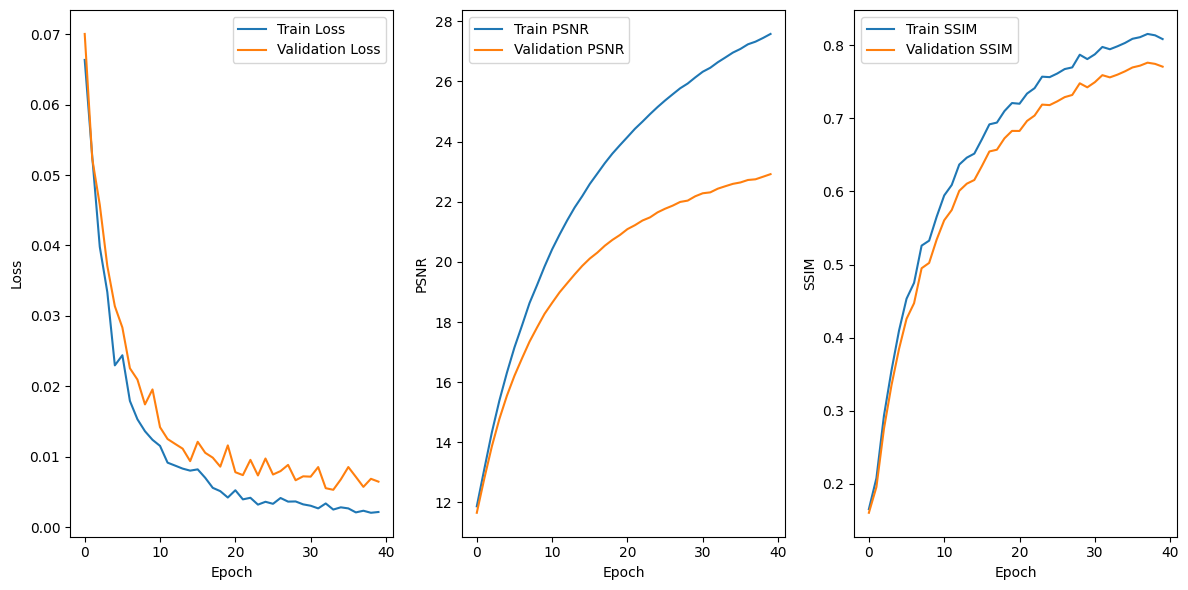

In [13]:
# plot Train and Test Loss, PSNR and SSIM values
autoencoder_model.plot_psnr_ssim()

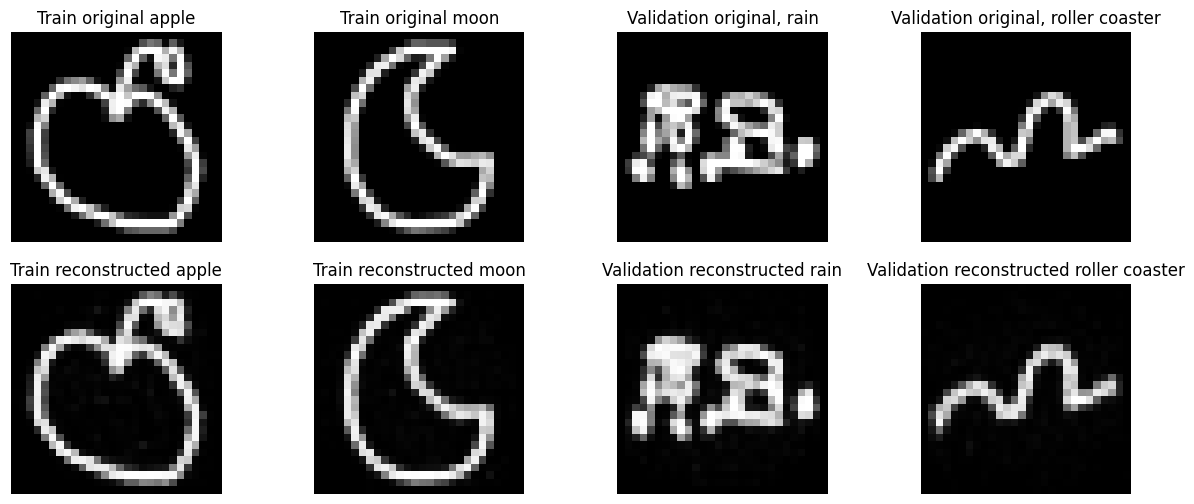

In [14]:
# plot some original and reconstructed images
autoencoder_model.show_images(training_set, validation_set)

In [15]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [16]:
# Show the lowest psnr then ssim in the test set
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]} | {lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]} | {lowest_ssim[1]}')

Lowest PSNR index: 254 | 16.636772394872686, Lowest SSIM index: 151 | 0.5415768803675906


[254, 16.636772394872686]
[151, 0.5415768803675906]


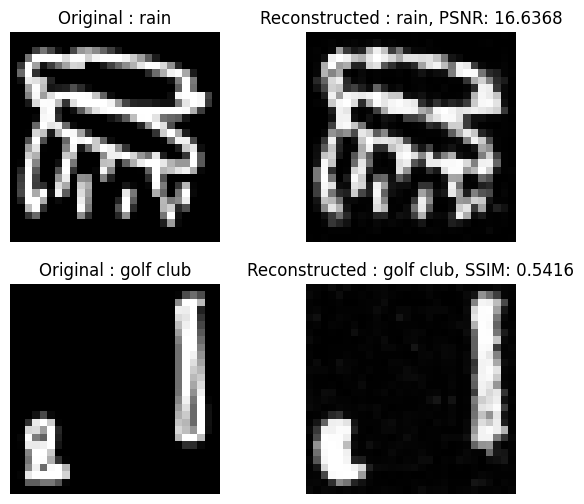

In [17]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
print(lowest_psnr)
print(lowest_ssim)
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Generating images

In [18]:
def return_classes_mean_encoded_vector(model, images_set):
    mean_encoded_vectors = []
    mean_vectors_size = model.architecture[-1]
    count_classes_number = [0] * nb_classes

    for i in range(nb_classes):
        mean_encoded_vectors.append(np.zeros(mean_vectors_size))

    for batch in images_set:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        encoded, decoded = model(images, labels=labels)
        encoded_np = encoded.cpu().detach().numpy()

        for i in range(len(images)):
            mean_encoded_vectors[labels[i]] += encoded_np[i]
            count_classes_number[labels[i]] += 1
            
    for i in range(nb_classes):
        mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i]

        print(f'Class {classes[i]} range of mean encoded vector: [{mean_encoded_vectors[i].min()}, {mean_encoded_vectors[i].max()}]')

    return mean_encoded_vectors

def generated_images_for_mean_vector(mean_encoded_vectors, model):
    generated_images = []

    decoder = model.decoder
    for i in range(nb_classes):
        mean_vector = mean_encoded_vectors[i]
        double_mean_vector = np.array([mean_vector]).astype(np.float32)
        mean_vector_torch = torch.from_numpy(double_mean_vector).to(device)

        decoded = decoder(mean_vector_torch)

        generated_images.append(decoded.cpu().detach().numpy()[0].reshape(HEIGHT, WIDTH))

    return generated_images

def show_generated_images(generated_images):
    num_cols = 4
    num_rows = 2

    _, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(nb_classes):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(generated_images[i], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(classes[i])

    plt.tight_layout()
    plt.suptitle('Generated images')

    plt.subplots_adjust(top=0.9)

    plt.show()

In [19]:
def create_alternative_version(mean_vector, weight=0.1):
    alternative_mean_vector = mean_vector.copy()
    # Vector is composed of float values 
    # use gaussian distribution to generate altertivate vector based on mean one

    for i in range(len(mean_vector)):
        alternative_mean_vector[i] = np.random.normal(mean_vector[i], weight)
    
    return alternative_mean_vector

In [20]:
from src.generator import ImageGenerator

image_generator = ImageGenerator(classes, device, autoencoder_model)

Class apple range of mean encoded vector: [-3.5972724752736007, 2.850031055698326]
Class golf club range of mean encoded vector: [-3.3748615563281477, 3.0730591902703597]
Class hedgehog range of mean encoded vector: [-4.210387307194482, 3.010386996960218]
Class moon range of mean encoded vector: [-3.517963785298017, 2.768510204492783]
Class mushroom range of mean encoded vector: [-3.73542268061247, 3.2589927730990236]
Class rain range of mean encoded vector: [-3.4812378784841744, 3.5164574655619534]
Class roller coaster range of mean encoded vector: [-2.8112013154342526, 3.441526775965925]
Class squirrel range of mean encoded vector: [-3.3139551831751453, 3.9032108204705374]


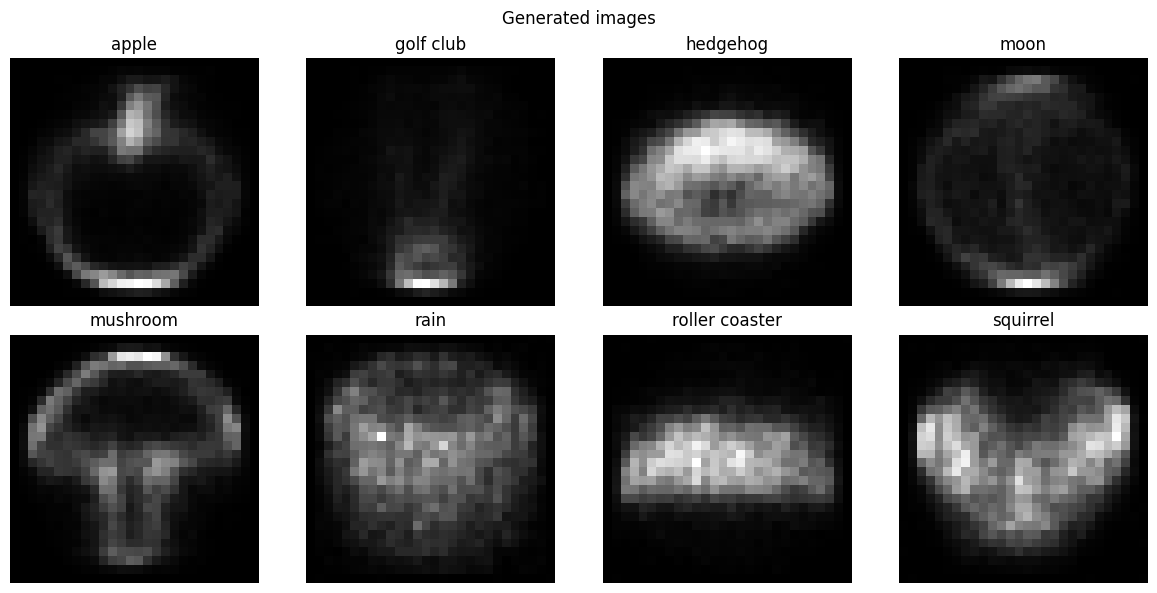

In [21]:
mean_encoded_vectors = image_generator.generate_mean_encoded_vectors_per_classes(
    training_loaded_set, conv_model=False)
image_generator.show_generated_images_per_mean_vectors(mean_encoded_vectors, image_size=(WIDTH, HEIGHT))

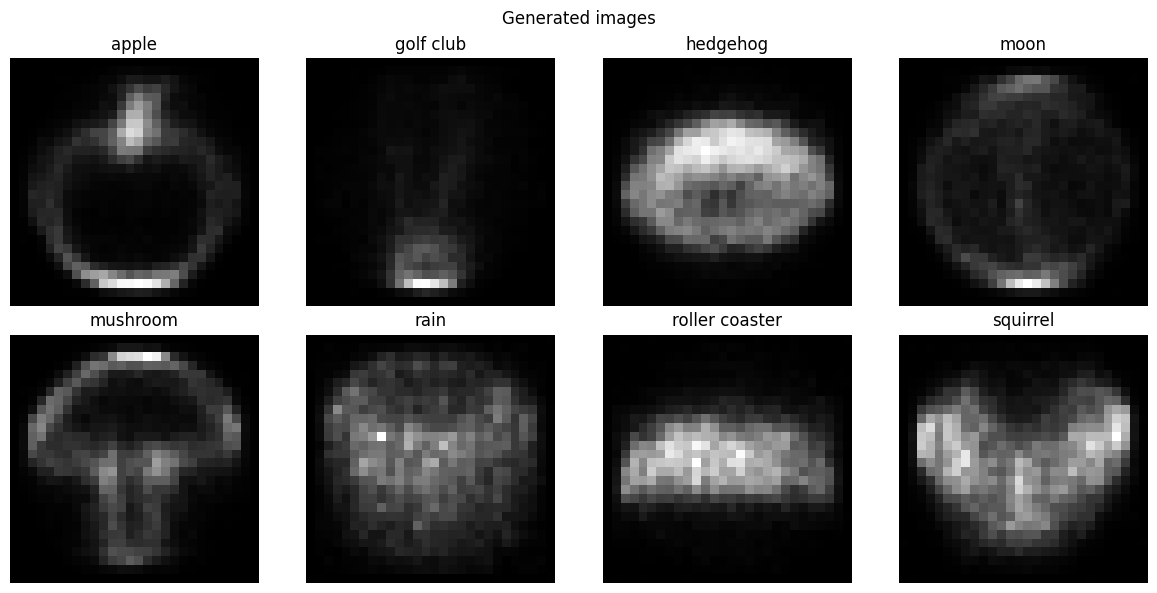

In [23]:
noised_encoded_vectors = image_generator.generate_noised_mean_vectors(mean_encoded_vectors, 0.05)
image_generator.show_generated_images_per_mean_vectors(noised_encoded_vectors, image_size=(WIDTH, HEIGHT))